### Vectorización de texto y modelo de clasificación Naïve Bayes con el dataset 20 newsgroups

In [95]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import f1_score

# 20newsgroups por ser un dataset clásico de NLP ya viene incluido y formateado
# en sklearn
from sklearn.datasets import fetch_20newsgroups
import numpy as np

## Carga de datos

In [96]:
# cargamos los datos (ya separados de forma predeterminada en train y test)
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

## Vectorización

In [97]:
# instanciamos un vectorizador
# ver diferentes parámetros de instanciación en la documentación de sklearn
tfidfvect = TfidfVectorizer()

In [98]:
# en el atributo `data` accedemos al texto
newsgroups_train.data[0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

In [99]:
# con la interfaz habitual de sklearn podemos fitear el vectorizador
# (obtener el vocabulario y calcular el vector IDF)
# y transformar directamente los datos
X_train = tfidfvect.fit_transform(newsgroups_train.data)
# `X_train` la podemos denominar como la matriz documento-término

In [100]:
# recordar que las vectorizaciones por conteos son esparsas
# por ello sklearn convenientemente devuelve los vectores de documentos
# como matrices esparsas
print(type(X_train))
print(f'shape: {X_train.shape}')
print(f'cantidad de documentos: {X_train.shape[0]}')
print(f'tamaño del vocabulario (dimensionalidad de los vectores): {X_train.shape[1]}')

<class 'scipy.sparse._csr.csr_matrix'>
shape: (11314, 101631)
cantidad de documentos: 11314
tamaño del vocabulario (dimensionalidad de los vectores): 101631


In [101]:
# una vez fiteado el vectorizador, podemos acceder a atributos como el vocabulario
# aprendido. Es un diccionario que va de términos a índices.
# El índice es la posición en el vector de documento.
tfidfvect.vocabulary_['car']

25775

In [102]:
# es muy útil tener el diccionario opuesto que va de índices a términos
idx2word = {v: k for k,v in tfidfvect.vocabulary_.items()}

In [103]:
# en `y_train` guardamos los targets que son enteros
y_train = newsgroups_train.target
y_train[:10]

array([ 7,  4,  4,  1, 14, 16, 13,  3,  2,  4])

In [104]:
# hay 20 clases correspondientes a los 20 grupos de noticias
print(f'clases {np.unique(newsgroups_test.target)}')
newsgroups_test.target_names

clases [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

## Similaridad de documentos

In [105]:
# Veamos similaridad de documentos. Tomemos algún documento
idx = 4811
print(newsgroups_train.data[idx])

THE WHITE HOUSE

                  Office of the Press Secretary
                   (Pittsburgh, Pennslyvania)
______________________________________________________________
For Immediate Release                         April 17, 1993     

             
                  RADIO ADDRESS TO THE NATION 
                        BY THE PRESIDENT
             
                Pittsburgh International Airport
                    Pittsburgh, Pennsylvania
             
             
10:06 A.M. EDT
             
             
             THE PRESIDENT:  Good morning.  My voice is coming to
you this morning through the facilities of the oldest radio
station in America, KDKA in Pittsburgh.  I'm visiting the city to
meet personally with citizens here to discuss my plans for jobs,
health care and the economy.  But I wanted first to do my weekly
broadcast with the American people. 
             
             I'm told this station first broadcast in 1920 when
it reported that year's presidential elec

In [106]:
# midamos la similaridad coseno con todos los documentos de train
cossim = cosine_similarity(X_train[idx], X_train)[0]

In [107]:
# podemos ver los valores de similaridad ordenados de mayor a menos
np.sort(cossim)[::-1]

array([1.        , 0.70930477, 0.67474953, ..., 0.        , 0.        ,
       0.        ])

In [108]:
# y a qué documentos corresponden
np.argsort(cossim)[::-1]

array([ 4811,  6635,  4253, ...,  1534, 10055,  4750])

In [109]:
# los 5 documentos más similares:
mostsim = np.argsort(cossim)[::-1][1:6]

In [110]:
# el documento original pertenece a la clase:
newsgroups_train.target_names[y_train[idx]]

'talk.politics.misc'

In [111]:
# y los 5 más similares son de las clases:
for i in mostsim:
  print(newsgroups_train.target_names[y_train[i]])

talk.politics.misc
talk.politics.misc
talk.politics.misc
talk.politics.misc
talk.politics.misc


### Modelo de clasificación Naïve Bayes

In [112]:
# es muy fácil instanciar un modelo de clasificación Naïve Bayes y entrenarlo con sklearn
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [113]:
# con nuestro vectorizador ya fiteado en train, vectorizamos los textos
# del conjunto de test
X_test = tfidfvect.transform(newsgroups_test.data)
y_test = newsgroups_test.target
y_pred =  clf.predict(X_test)

In [114]:
# el F1-score es una metrica adecuada para reportar desempeño de modelos de claificación
# es robusta al desbalance de clases. El promediado 'macro' es el promedio de los
# F1-score de cada clase. El promedio 'micro' es equivalente a la accuracy que no
# es una buena métrica cuando los datasets son desbalanceados
f1_score(y_test, y_pred, average='macro')

0.5854345727938506

## Consigna del desafío 1

**1**. Vectorizar documentos. Tomar 5 documentos al azar y medir similaridad con el resto de los documentos.
Estudiar los 5 documentos más similares de cada uno analizar si tiene sentido
la similaridad según el contenido del texto y la etiqueta de clasificación.

**2**. Entrenar modelos de clasificación Naïve Bayes para maximizar el desempeño de clasificación
(f1-score macro) en el conjunto de datos de test. Considerar cambiar parámteros
de instanciación del vectorizador y los modelos y probar modelos de Naïve Bayes Multinomial
y ComplementNB.

**3**. Transponer la matriz documento-término. De esa manera se obtiene una matriz
término-documento que puede ser interpretada como una colección de vectorización de palabras.
Estudiar ahora similaridad entre palabras tomando 5 palabras y estudiando sus 5 más similares. **La elección de palabras no debe ser al azar para evitar la aparición de términos poco interpretables, elegirlas "manualmente"**.


### **1**. Vectorizar documentos. Tomar 5 documentos al azar y medir similaridad con el resto de los documentos. Estudiar los 5 documentos más similares de cada uno analizar si tiene sentido la similaridad según el contenido del texto y la etiqueta de clasificación.

Para resolver este ejercicio se reutiliza parte del código presentado en la introducción. Básicamente, se toman cinco elementos al azar del conjunto de entrenamiento y se buscan los 5 más similares para analizar cuál fue su clasificación comparada con el original.

In [115]:
import random

# Se setea seed para reproducibilidad de las pruebas
random.seed(3)

# Se obtienen los índices de 5 ejemplos aleatorios del conjunto de entrenamiento
doc_indexes = random.sample(range(len(newsgroups_train.data)), 5)

for line_id, idx in enumerate(doc_indexes):
    print(f"{'#'*20} {line_id+1} - Documento con índice {idx} {'#'*20}")
    print(newsgroups_train.data[idx])

    # Se calcula la similaridad coseno entre el ejemplo y el resto de los documentos en entrenamiento.
    # Se utiliza el índice '[0]' dado que estamos comparando sólo un ejemplo contra todo el resto
    cossim = cosine_similarity(X_train[idx], X_train)[0]

    # Se obtienen sólo los 5 documentos más similares a modo de ejemplo
    mostsim = np.argsort(cossim)[::-1][1:6]

    # Se muestran las clases de dichos documentos más similares
    print(f"{'#'*20} Clase del documento {idx} {'#'*20}")
    print(newsgroups_train.target_names[y_train[idx]])
    print(f"{'-'*10} Clases de los 5 documentos más similares {'-'*10}")
    for i in mostsim:
        print(newsgroups_train.target_names[y_train[i]])
    print("\n")

#################### 1 - Documento con índice 3898 ####################
	The part about spending $5000-7000 on repairs reminds me
of an article I read in a magazine comparing the 5 year ownership costs
of a Toyota Camry and a Ford Taurus or something like that.  The result,
which they announced with great flourish was that it cost the same at the
end of the period.  That was their argument to prove that you don't go
wrong buying the Ford Taurus over the Camry.

	Now, if I remember correctly, the Camry costs about $4000 or so more
in initial costs.  Essentially, it means that you spend about $4000 extra
on repairs on the Taurus.  That is ridiculous.  Every time your car
needs repairs, it is extra hassles, loss of time and a dozen other things.
I would much rather spend $5000 more in initial costs than spend $4000 more
in repair costs.

#################### Clase del documento 3898 ####################
rec.autos
---------- Clases de los 5 documentos más similares ----------
rec.autos
rec

Por lo general, se puee observar que los documentos más similares tienden a pertenecer a la misma categoría del documento original. Esto tiene sentido, ya que la similaridad coseno mide qué tan cercanos son los vectores que representan estos documentos.

De todas formas es importante tener en cuenta que esta medida depende fuertemente del método de vectorización utilizado y que es posible (con menor probabilidad) encontrar documentos con alta similaridad coseno que en realidad traten temas diferentes.

#### **2**. Entrenar modelos de clasificación Naïve Bayes para maximizar el desempeño de clasificación (f1-score macro) en el conjunto de datos de test. Considerar cambiar parámteros de instanciación del vectorizador y los modelos y probar modelos de Naïve Bayes Multinomial y ComplementNB.

Para resolver este ejercicio se inicializará la clase TfidfVectorizer variando los siguientes hiperparámetros que podrían tener efectos significativos en la clasificación:

- **max_df** ***(maximum document frequency)***: Umbral superior de frecuencia de documentos.
- **min_df** ***(minimum document frequency)***: Umbral inferior de frecuencia de documentos.
- **ngram_range_values**: Define el rango de n-gramas que utilizará el vectorizador.

Además, también se incluyó el parámetro *alpha* que utilizan los clasificadores MultinomialNB y ComplementNB para determinar si se incluye *smoothing* de Laplace (valor 1.0) o Lidstone (distinto de 1.0). Su principal función es evitar problemas relacionados con palabras que no aparecen en ningún documento y así "suavizar" las probabilidades.

Para el tuneo de los hiperparamétros de realizará una búsqueda en grilla (*Grid Search*). Dado que es un caso simple, no se utilizará ninguna librería externa para el proceso.

In [116]:
# Tuneo de parámetros de TfidfVectorizer
max_df_values = [0.8, 0.9]
min_df_values = [1, 10, 20]
ngram_range_values = [(1, 2), (1, 3)]
alpha_values = [0.1, 0.5, 1.0]

best_f1_score = 0
best_params = {}

for max_df in max_df_values:
    for min_df in min_df_values:
        for ngram_range in ngram_range_values:
            for alpha in alpha_values:

              # Se instancia el vectorizador con los parámetros actuales
              tfidfvect_new = TfidfVectorizer(max_df=max_df, min_df=min_df, ngram_range=ngram_range)
              X_train_new = tfidfvect_new.fit_transform(newsgroups_train.data)
              X_test_new = tfidfvect_new.transform(newsgroups_test.data)

              # Se entrena el modelo MultinomialNB
              clf_multiNB = MultinomialNB(alpha=alpha)
              clf_multiNB.fit(X_train_new, y_train)
              y_pred_multiNB = clf_multiNB.predict(X_test_new)
              f1_score_multiNB = f1_score(y_test, y_pred_multiNB, average='macro')
              print(f"F1-score (macro) con MultinomialNB y parámetros: max_df={max_df}, min_df={min_df}, ngram_range={ngram_range}, alpha={alpha}: {f1_score_multiNB}")

              # Se entrena el modelo ComplementNB
              clf_complNB = ComplementNB(alpha=alpha)
              clf_complNB.fit(X_train_new, y_train)
              y_pred_complNB = clf_complNB.predict(X_test_new)
              f1_score_complNB = f1_score(y_test, y_pred_complNB, average='macro')
              print(f"F1-score (macro) con ComplementNB y parámetros: max_df={max_df}, min_df={min_df}, ngram_range={ngram_range}, alpha={alpha}: {f1_score_complNB}")

              if f1_score_multiNB > best_f1_score:
                  best_f1_score = f1_score_multiNB
                  best_params = {'max_df': max_df, 'min_df': min_df, 'ngram_range': ngram_range, 'model': 'MultinomialNB', 'alpha': alpha}
              if f1_score_complNB > best_f1_score:
                  best_f1_score = f1_score_complNB
                  best_params = {'max_df': max_df, 'min_df': min_df, 'ngram_range': ngram_range, 'model': 'ComplementNB', 'alpha': alpha}

print(f"Mejores parámetros: {best_params}")
print(f"Mejor F1-score: {best_f1_score}")

F1-score (macro) con MultinomialNB y parámetros: max_df=0.8, min_df=1, ngram_range=(1, 2), alpha=0.1: 0.6229617848305139
F1-score (macro) con ComplementNB y parámetros: max_df=0.8, min_df=1, ngram_range=(1, 2), alpha=0.1: 0.7061737066021505
F1-score (macro) con MultinomialNB y parámetros: max_df=0.8, min_df=1, ngram_range=(1, 2), alpha=0.5: 0.5736660169567053
F1-score (macro) con ComplementNB y parámetros: max_df=0.8, min_df=1, ngram_range=(1, 2), alpha=0.5: 0.6925182378837313
F1-score (macro) con MultinomialNB y parámetros: max_df=0.8, min_df=1, ngram_range=(1, 2), alpha=1.0: 0.5430237308915067
F1-score (macro) con ComplementNB y parámetros: max_df=0.8, min_df=1, ngram_range=(1, 2), alpha=1.0: 0.6816487615044463
F1-score (macro) con MultinomialNB y parámetros: max_df=0.8, min_df=1, ngram_range=(1, 3), alpha=0.1: 0.6063331842718382
F1-score (macro) con ComplementNB y parámetros: max_df=0.8, min_df=1, ngram_range=(1, 3), alpha=0.1: 0.6917872351757025
F1-score (macro) con MultinomialNB y

Luego de realizada la búsqueda de hiperparámetros, se obtuvo el mejor resultado con la siguiente configuración:

- Modelo: ComplementNB
- min_df: 1
- max_df: 0.8
- ngram_range: (1, 2)
- alpha: 0.1

El F1-score obtenido fue de ~0.706, el cual mejora el valor original de ~0.585. Notar que el modelo que mejores resultados dio fue ComplementNB, que mejora el rendimiento en situaciones en que las clases están desequilibradas. Para validar si estamos en esa situación a continuación se muestran los histogramas para entrenamiento y test.

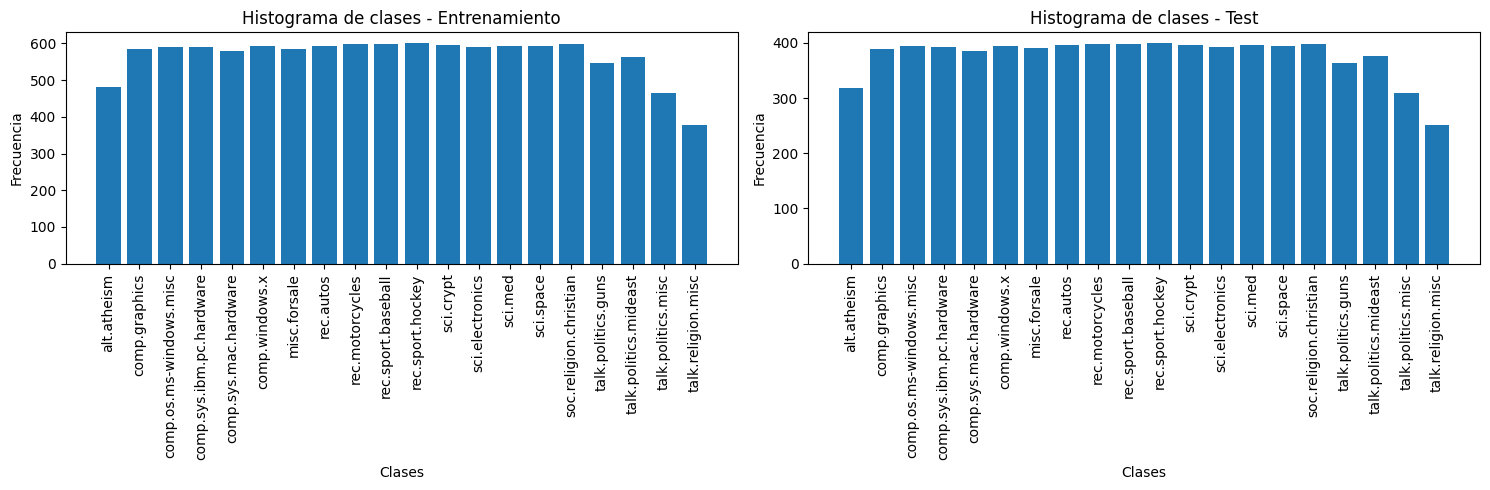

In [117]:
import matplotlib.pyplot as plt

# Se calculan los histogramas para entrenamiento y test
train_hist = np.histogram(y_train, bins=range(len(newsgroups_train.target_names) + 1))
test_hist = np.histogram(y_test, bins=range(len(newsgroups_test.target_names) + 1))

# Se grafican los histogramas
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histograma de entrenamiento
axes[0].bar(train_hist[1][:-1], train_hist[0])
axes[0].set_xticks(train_hist[1][:-1])
axes[0].set_xticklabels(newsgroups_train.target_names, rotation=90)
axes[0].set_title('Histograma de clases - Entrenamiento')
axes[0].set_xlabel('Clases')
axes[0].set_ylabel('Frecuencia')

# Histograma de test
axes[1].bar(test_hist[1][:-1], test_hist[0])
axes[1].set_xticks(test_hist[1][:-1])
axes[1].set_xticklabels(newsgroups_test.target_names, rotation=90)
axes[1].set_title('Histograma de clases - Test')
axes[1].set_xlabel('Clases')
axes[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Tal como se aprecia, si bien por lo general hay una buena distribución de las clases, hay algunos clases que notoriamente presentan menos datos, como por ejemplo *talk.religion.misc*. Es tal vez por este motivo que *ComplementNB* presenta mejores métricas que *MultinomialNB*.

#### **3**. Transponer la matriz documento-término. De esa manera se obtiene una matriz término-documento que puede ser interpretada como una colección de vectorización de palabras. Estudiar ahora similaridad entre palabras tomando 5 palabras y estudiando sus 5 más similares. **La elección de palabras no debe ser al azar para evitar la aparición de términos poco interpretables, elegirlas "manualmente"**.

In [118]:
# Se transpone la matriz documento-término
X_train_transpose = X_train.transpose()
X_train_transpose

<101631x11314 sparse matrix of type '<class 'numpy.float64'>'
	with 1103627 stored elements in Compressed Sparse Column format>

In [119]:
# Se definen las palabras a analizar
palabras = ['floppy', 'nuclear', 'game', 'windows', 'god']

# Se itera sobre las palabras
for palabra in palabras:
    # Se obtiene el índice de la palabra en el vocabulario
    idx_palabra = tfidfvect.vocabulary_[palabra]

    # Se calcula la similaridad coseno entre la palabra y el resto de las palabras
    cossim_palabras = cosine_similarity(X_train_transpose[idx_palabra], X_train_transpose)[0]

    # Se obtienen las 5 palabras más similares
    mostsim_palabras = np.argsort(cossim_palabras)[::-1][1:6]

    # Se muestran las palabras más similares
    print(f"{'#'*20} {palabra} {'#'*20}")
    for i in mostsim_palabras:
        print(idx2word[i])
    print("\n")

#################### floppy ####################
drive
disk
floppies
drives
kludge


#################### nuclear ####################
plants
towers
reactor
fossil
radioactives


#################### game ####################
games
espn
hockey
team
scored


#################### windows ####################
dos
ms
microsoft
nt
for


#################### god ####################
jesus
bible
that
existence
christ




Los resultados reflejan que las palabras seleccionadas comparten contextos comunes con las palabras que se les encuentran más similares. Esto resultado se da por cómo el TF-IDF vectoriza los términos y cómo la similaridad coseno identifica términos que suelen aparecer en contextos similares dentro de los documentos analizados. Para que los resultados fuesen más notorios se eligieron palabras que tengan un significado poco ambiguo y se evitaron utilizar términos que son comunes a todos los documentos.

El código que se muestra a continuación se utilizó para analizar los contextos en los que se presentaban las palabras más similares. Se muestra sólo un ejemplo a modo ilustrativo.

In [120]:
# Función auxiliar que se utilizó para buscar palabras poco comunes en su contexto
def get_document_by_word(word, data):
    for i, document in enumerate(data):
        if word.lower() in document.lower():
            return document
    return None

In [121]:
word_to_find = "kludge"
document_with_word = get_document_by_word(word_to_find, newsgroups_train.data)

if document_with_word:
    print(f"Documento que contiene la palabra '{word_to_find}':\n{document_with_word}")
else:
    print(f"No se encontró ningún documento que contenga la palabra '{word_to_find}'.")


Documento que contiene la palabra 'kludge':
Is there a fast 'n dirty way to kill the line spiking that occurs when
an inductive load is turned on sometime other than at zero-crossing of
the AC cycle?  A capacitor kludged in somehow, etc?

I've got a microcontroller that is running a bunch of valves and pumps
in a big instrument washer, and almost everything is being switched with
zero-crossing solid state relays, so that stuff stays "quiet", AC-wise.
But there's one steam valve that gets turned on by a mechanical relay
in the water tank fill/thermostat system, and it's not under control
of my SSRs, and it does sometimes generate/radiate a spike that resets
one of my peripheral chips.  My software times out and tries again, but
I'd love to just tack in a magic spike-killing fix that would avoid having
to do some major rewiring/redesign.  A varistor would help but might not
be sufficient.  Ideas?

